In [1]:
!apt-get install -y libav-tools libasound2-dev libsndfile1-dev libjack-dev
!git clone https://github.com/AnnaRemi/BachelorThesis/ data

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'libav-tools' has no installation candidate
Cloning into 'data'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 94 (delta 10), reused 53 (delta 5), pack-reused 24
Receiving objects: 100% (94/94), 91.40 MiB | 29.73 MiB/s, done.
Resolving deltas: 100% (10/10), done.


We should now have access to the code:

In [2]:
import sys
import numpy as np
from numpy import ndarray
import soundfile as sf
from IPython.display import Audio
from skimage.util import img_as_ubyte

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
%matplotlib inline

from matplotlib.pyplot import imread
from skimage.transform import resize, rotate

import torch, torch.nn as nn
from torch.nn.functional import mse_loss
from torch.autograd import Variable
from torch import Tensor, from_numpy, hann_window

import torchvision.models as models
from torchvision.transforms import Compose, ToPILImage, Resize
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

from PIL import Image

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [4]:
transform_spectra = Compose([
    ToPILImage(),
    Resize((257,257)),
    # transforms.RandomVerticalFlip(1)
])

def normalize(tensor: Tensor) -> Tensor:
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

def normalize_nd(tensor: ndarray) -> ndarray:
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/np.absolute(tensor_minusmean).max()

def make0min(tensornd: Tensor) -> Tensor:
    tensor = tensornd.numpy()
    res = np.where(tensor == 0, 1E-19 , tensor)
    return from_numpy(res)

def SpectToImage(waveform: Tensor) -> Image:
    spectrogram = T.Spectrogram(
        n_fft=512,
        win_length=None,
        hop_length=None,
        pad=0,
        window_fn=hann_window,
        power=2,
        normalized=True,
        wkwargs=None)(waveform)

    spectrogram = make0min(spectrogram)
    specgram: ndarray = spectrogram.log2()[0,:,:].numpy()

    np.set_printoptions(linewidth=300)
    np.set_printoptions(threshold=sys.maxsize)

    specgram = normalize_nd(specgram)
    specgram = img_as_ubyte(specgram)

    specgramImage: Image = transform_spectra(specgram)

    return specgramImage

In [5]:
def spec_from_audio(audio):
  waveform, sample_rate = torchaudio.load(audio, normalize=True)
  image = SpectToImage(waveform)
  # print(type(image))
  image = image.convert('RGB')
  image = np.array(image)

  spectrogram = T.Spectrogram(n_fft=512)
  wspec = spectrogram(waveform)
  return wspec, sample_rate, image

Let's grab some audio to play with and then try stylizing it.  First the style:

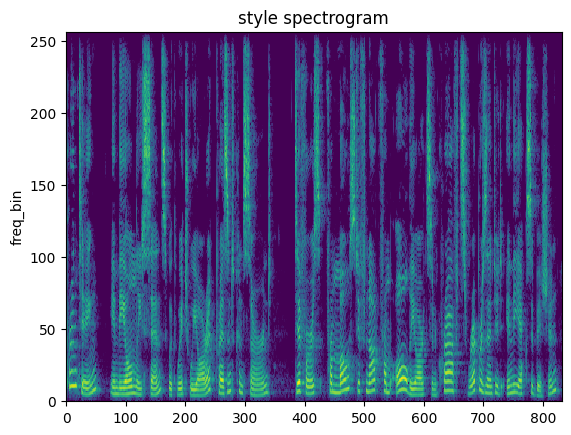

In [6]:
# style_audio = "data/sounds/corpus/johntejada-1.wav"
style_audio = "data/dataset/wavs/LJ001-0001.wav"
style_image, sr, style_rgb = spec_from_audio(style_audio)

plot_spectrogram(style_image[0], title="style spectrogram")

In [7]:
Audio(style_audio, rate=sr)

Now the content:

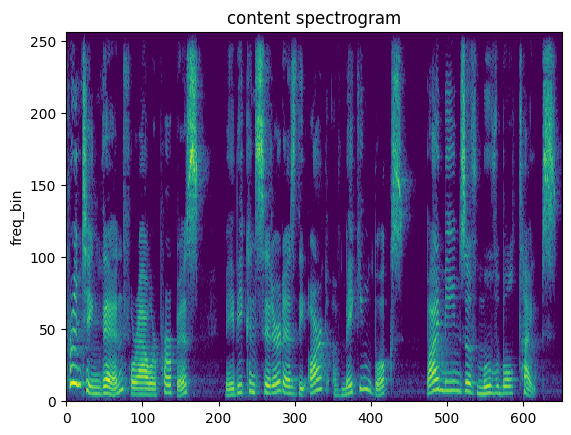

In [17]:
# content_audio = 'data/sounds/target/beat-box-1.wav'
content_audio = "data/dataset/wavs/LJ001-0009.wav"
content_image, sr, content_rgb = spec_from_audio(content_audio)

plot_spectrogram(content_image[0], title="content spectrogram")

In [18]:
Audio(content_audio, rate=sr)

And now let's try synthesizing.  In general, most parameters with higher settings produce more desirable results (except for `hop_length` and `stride` which are often better with smaller values).

# Implementation

##Data load

In [10]:
use_cuda = torch.cuda.is_available()

print("torch", torch.__version__)
if use_cuda:
    print("Using GPU.")
else:
    print("Not using GPU.")

torch 2.1.0+cu118
Not using GPU.


In [11]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 111MB/s] 


In [12]:
# imsize = 257
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [13]:
def imshow(tensor, title=None):
    imsize_x, imsize_y = tensor.shape[2], tensor.shape[-1]

    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize_x, imsize_y)  # remove the fake batch dimension
    image = image.numpy().transpose([1,2,0])
    plt.imshow(image / np.max(image))
    if title is not None:
        plt.title(title)


In [15]:
def image_loader(input_image):
    imsize_x, imsize_y = input_image.shape[0], input_image.shape[1]

    image = resize(input_image, [imsize_x, imsize_y])
    image = image.transpose([2,0,1]) / image.max()
    image = Variable(dtype(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [19]:
style_img = image_loader(style_rgb)
content_img = image_loader(content_rgb)

In [20]:
style_img.shape

torch.Size([1, 3, 257, 257])

In [21]:
type(style_img)

torch.Tensor

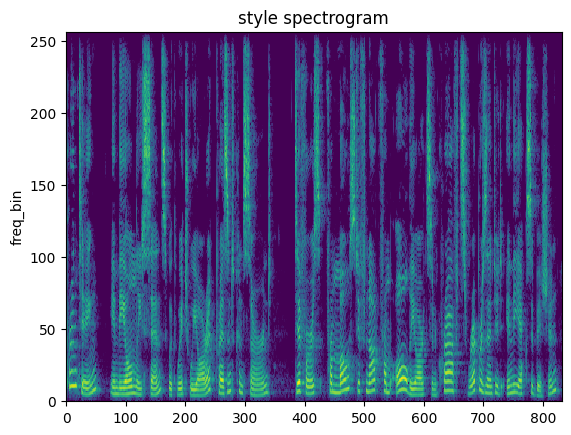

In [23]:
plot_spectrogram(style_image[0], title="style spectrogram")

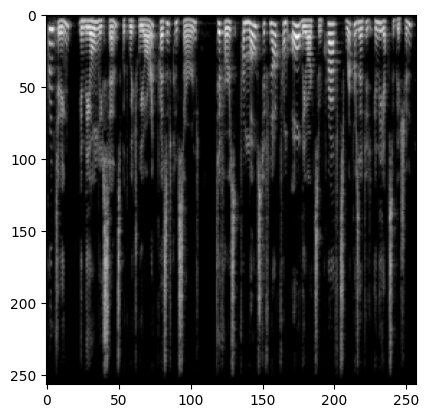

In [22]:
imshow(style_img)

##Losses and net itself

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.loss = mse_loss(input * self.weight, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.G = gram_matrix(input)
        self.G.mul_(self.weight)
        self.loss = mse_loss(self.G, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [ ]:
content_weight=5            # coefficient for content loss
style_weight=100             # coefficient for style loss
content_layers=('conv_4',)   # use these layers for content loss
style_layers=('conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5') # use these layers for style loss

In [ ]:
content_losses = []
style_losses = []

model = nn.Sequential()
# the new Sequential module network
# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)

<ipython-input-49-423d5464ac4f>:10: UserWarning: Using a target size (torch.Size([1, 128, 128, 325])) that is different to the input size (torch.Size([1, 128, 128, 416])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = mse_loss(input * self.weight, self.target)


RuntimeError: ignored

In [ ]:
input_image = Variable(content_img.clone().data, requires_grad=True)
optimizer = torch.optim.Adam([input_image], lr=0.1)

In [ ]:
num_steps = 80

for i in range(num_steps):
    # correct the values of updated input image
    input_image.data.clamp_(0, 1)

    model(input_image)
    style_score = 0
    content_score = 0
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()

    if i % 10 == 0:  # <--- adjust the value to see updates more frequently

        print('Step # {} Style Loss : {:4f} Content Loss: {:4f}'.format(
            i, style_score.data.item(), content_score.item()))
        print('\n')
        # plt.figure(figsize=[10,10])
        # imshow(input_image.data)
        # plt.show()

    loss = style_score + content_score

    optimizer.step(lambda: loss)
    optimizer.zero_grad()

# a last correction...
input_image.data.clamp_(0, 1)

##Final image

In [ ]:
plt.figure(figsize=[10,10])
imshow(input_image.data)
plt.show()

In [ ]:
type(input_image.data)

In [ ]:
input_image.shape

In [30]:
def image_reloader(input_image):
  imsize_x, imsize_y = input_image.shape[-2], input_image.shape[-1]

  input_image_copy = input_image.data.clone().cpu()
  input_image_copy = input_image_copy.view(3, imsize_x, imsize_y)  # remove the fake batch dimension

  # transform = ToPILImage()
  transform = Compose([
    ToPILImage(),
    # Resize((imsize, imsize)),
    ])
  final_img = transform(input_image_copy)
  return final_img

In [ ]:
final_img = image_reloader(input_image)

In [ ]:
type(final_img)
print(final_img.size)

In [ ]:
final_img

#Convert Image to Sound

In [35]:
import math, wave, array, sys, getopt

def start(image, outputfile, duration):
    width, height = image.size
    rgb_im = image.convert('RGB')

    durationSeconds = float(duration)
    tmpData = []
    maxFreq = 0
    data = array.array('h')
    sampleRate = 44100
    channels = 1
    dataSize = 2

    numSamples = int(sampleRate * durationSeconds)
    samplesPerPixel = math.floor(numSamples / width)

    C = 20000 / height

    for x in range(numSamples):
      rez = 0

      pixel_x = int(x / samplesPerPixel)
      if pixel_x >= width:
          pixel_x = width -1

      for y in range(height):
          r, g, b = rgb_im.getpixel((pixel_x, y))
          s = r + g + b

          volume = s * 100 / 765

          if volume == 0:
              continue

          freq = int(C * (height - y + 1))

          rez += getData(volume, freq, sampleRate, x)

      tmpData.append(rez)
      if abs(rez) > maxFreq:
          maxFreq = abs(rez)

    for i in range(len(tmpData)):
        data.append(32767 * tmpData[i] // maxFreq)

    sf.write(outputfile, data, sampleRate)

def getData(volume, freq, sampleRate, index):
    return int(volume * math.sin(freq * math.pi * 2 * index /sampleRate))

In [ ]:
# <input_picture> <output.wav> <duration_seconds>
# inputfile = final_img
# outputfile = 'output.wav'
# duration = '10'

# start(inputfile, outputfile, duration)

In [ ]:
# Audio('output.wav')

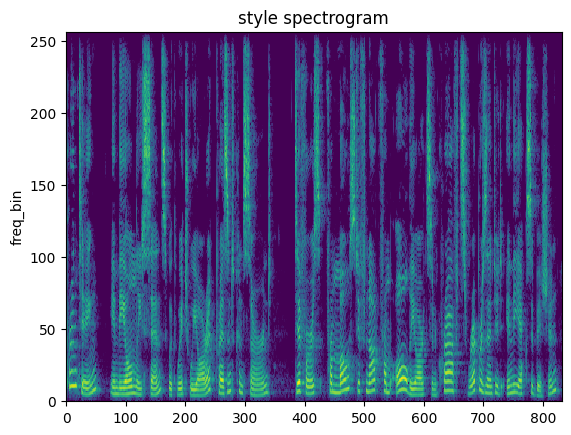

In [26]:
style_audio = "data/dataset/wavs/LJ001-0001.wav"
style_image, sr, style_rgb = spec_from_audio(style_audio)

plot_spectrogram(style_image[0], title="style spectrogram")

In [27]:
Audio(style_audio, rate=sr)

In [31]:
style_img.shape

torch.Size([1, 3, 257, 257])

In [32]:
test_style_img = image_reloader(style_img)

In [36]:
inputfile = test_style_img
outputfile = 'test.wav'
duration = '9'

start(inputfile, outputfile, duration)

In [37]:
final_img.size

NameError: ignored

In [38]:
Audio('test.wav')